### PCA

Example process for pruning and running PCA on 1KG data subset.

In [1]:
from lib import api
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
%run nb/paths.py
%run nb/backends.py
%run nb/plotting.py

In [2]:
path = PLINK_1KG_PATH_02
path

PosixPath('/lab/data/gwas/tutorial/2_PS_GWAS/1kG_MDS5')

### Load 1KG call data

In [3]:
%%time
ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
ds = ds.sel(variant=ds.contig==1)
ds

CPU times: user 41.9 s, sys: 4.68 s, total: 46.6 s
Wall time: 29.2 s


<xarray.Dataset>
Dimensions:     (sample: 629, variant: 463525)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 463520 463521 463522 463523 463524
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 622 623 624 625 626 627 628
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(213382, 629), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(213382, 629), meta=np.ndarray>
    sample_id   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    fam_id      (sample) object dask.array<chunksize=(629,), meta=np.ndarray>
    pat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    mat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(463525,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(463525,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(463525,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(463525,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(463525,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(463525,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

### Compute Row Intervals

Options here include backends for parallel ("dask") or serial ("numba") calculations per-contig.

In [4]:
api.config.describe('axis_intervals')

stats.axis_intervals.backend Options: ['numba', 'dask']; default is auto
    [default: auto] [currently: numba]


In [5]:
%%time
window, threshold, target_chunk_size = 100_000, 0.2, 100_000
intervals = api.axis_intervals(ds, window=window, unit='physical', target_chunk_size=target_chunk_size)

CPU times: user 3.6 s, sys: 253 ms, total: 3.85 s
Wall time: 3.84 s


In [6]:
# intervals = (axis_intervals, chunk_intervals)
ais, cis = intervals
ais.to_dataset('var').to_dataframe().head(3)

,group,index,start,stop,count
axis,,,,,
0,1,0,0,56,56
1,1,1,1,56,55
2,1,2,2,56,54


Show distribution of how many variants are in each base pair window:

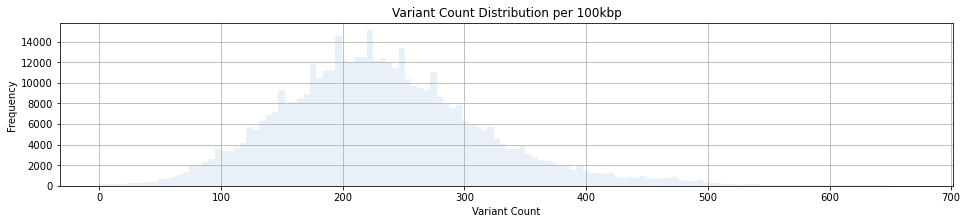

In [9]:
df = ais.to_dataset('var').to_dataframe()
for k, g in df.groupby('group'):
    ax = g['count'].hist(label=k, bins=128, figsize=(16, 3), alpha=.1)
ax.set_title(f'Variant Count Distribution per {window/1000:.0f}kbp')
ax.set_xlabel('Variant Count')
ax.set_ylabel('Frequency'); None

### LD Distribution

Show R2 distribution for comparison to the same distribution after pruning.

In [11]:
# Use single-threaded GPU backend
ldm = api.ld_matrix(ds, intervals=intervals, threshold=None, backend='dask/cuda')
ldm

,i,j,value
npartitions=1,,,
,int32,int32,float32
,...,...,...


CPU times: user 13.6 s, sys: 1.98 s, total: 15.6 s
Wall time: 15.5 s


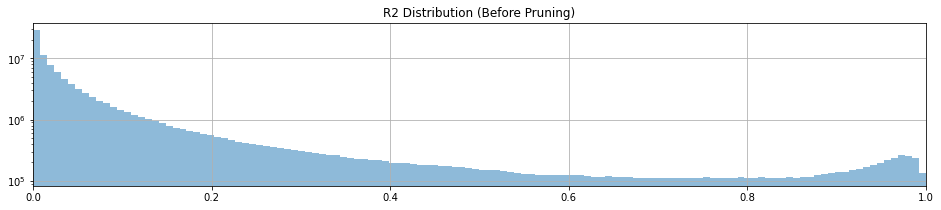

In [12]:
%%time
ax = ldm[ldm['i'] != ldm['j']].value.compute(scheduler='single-threaded').hist(bins=128, figsize=(16, 3), alpha=.5)
ax.set_xlim(0, 1)
ax.set_yscale('log')
ax.set_title('R2 Distribution (Before Pruning)'); None

Show the LD matrix, rotated by 45 degrees.  The dark blue indicates comparisons that were not made due to variants being too far away along the genome:

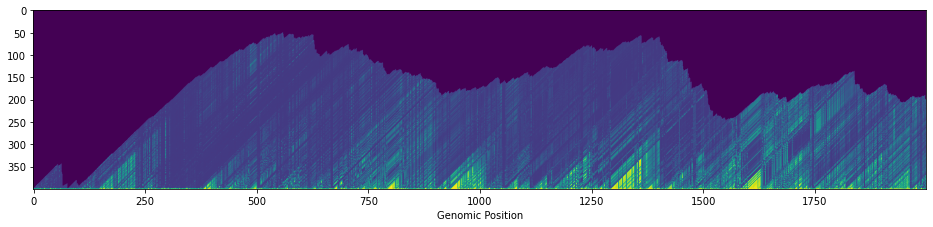

In [13]:
n, m = 2000, 400
df = ldm[ldm['i'] < n].compute(scheduler='single-threaded')
ld_plot(ld_image(df, n, m, .1))

### Pruning

In [14]:
api.config.describe('maximal_independent_set')

graph.maximal_independent_set.backend Options: ['numba', 'dask', 'networkx']; default is auto
    [default: auto] [currently: dask]


In [15]:
%%time
# Use the intervals as already defined but pass a new threshold 
index_to_drop = api.ld_prune(ds, intervals=intervals, threshold=threshold)\
    .index_to_drop.compute(scheduler='single-threaded')
dsp = ds.sel(variant=~ds.variant.isin(index_to_drop))
dsp

CPU times: user 1min 26s, sys: 1.5 s, total: 1min 27s
Wall time: 1min 27s


<xarray.Dataset>
Dimensions:     (sample: 629, variant: 40080)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 463508 463520 463522 463523 463524
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 622 623 624 625 626 627 628
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(17491, 629), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(17491, 629), meta=np.ndarray>
    sample_id   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    fam_id      (sample) object dask.array<chunksize=(629,), meta=np.ndarray>
    pat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    mat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

Show new R2 distribution:

CPU times: user 4.23 s, sys: 926 ms, total: 5.15 s
Wall time: 5.14 s


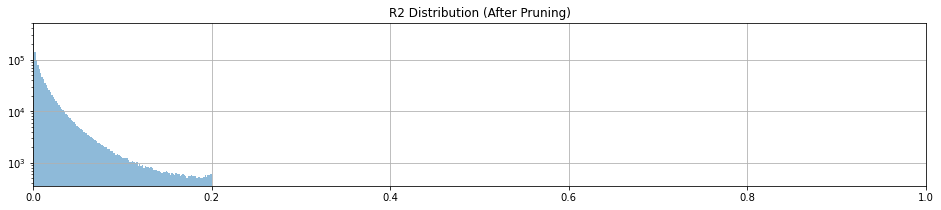

In [16]:
%%time
intervals = api.axis_intervals(dsp, window=window, unit='physical', target_chunk_size=target_chunk_size)
ldm = api.ld_matrix(dsp, intervals, threshold=None)
ax = ldm[ldm['i'] != ldm['j']].value.compute(scheduler='single-threaded').hist(bins=128, figsize=(16, 3), alpha=.5)
ax.set_xlim(0, 1)
ax.set_yscale('log')
ax.set_title('R2 Distribution (After Pruning)'); None

### Metadata

Load and attach 1KG metdata to get populations for each sample:

In [81]:
dsm = xr.Dataset.from_dataframe(
    pd.read_csv(CSV_1KG_POP, sep='\s+', names=['fam_id', 'pop', 'seq'])
    .rename_axis('sample', axis='rows')
)
dsm = dsm.set_index(sample='fam_id')
dsm

<xarray.Dataset>
Dimensions:  (sample: 629)
Coordinates:
  * sample   (sample) object 'HG00098' 'HG00100' ... 'NA20826' 'NA20828'
Data variables:
    pop      (sample) object 'GBR' 'GBR' 'GBR' 'GBR' ... 'TSI' 'TSI' 'TSI' 'TSI'
    seq      (sample) object 'ILLUMINA' 'ILLUMINA' ... 'ILLUMINA' 'ILLUMINA'

In [82]:
dsa = (
    dsp.set_index(sample='fam_id')
    .assign(pop=dsm.pop)
    .rename_vars(sample='fam_id')
    .reset_index(['fam_id', 'variant'], drop=True)
)
dsa

<xarray.Dataset>
Dimensions:     (sample: 629, variant: 40080)
Dimensions without coordinates: sample, variant
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(17491, 629), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(17491, 629), meta=np.ndarray>
    sample_id   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    pat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    mat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    pop         (sample) object 'GBR' 'GBR' 'GBR' 'GBR' ... 'TSI' 'TSI' 'TSI'
Attributes:
    type:     GenotypeCountDataset

### PCA

In [21]:
def rescale(x, ploidy=2):
    """Scale variant vectors"""
    # From PattersonScaler:
    # https://github.com/cggh/scikit-allel/blob/961254bd583572eed7f9bd01060e53a8648e620c/allel/stats/preprocessing.py
    # https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190
    mean = x.mean(dim='sample')
    p = mean / ploidy
    std = np.sqrt(p * (1 - p))
    return (x - mean) / std
x = rescale(dsa.data)
x

<xarray.DataArray 'data' (variant: 40080, sample: 629)>
dask.array<truediv, shape=(40080, 629), dtype=float64, chunksize=(19180, 629), chunktype=numpy.ndarray>
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 ... 463508 463520 463522 463523 463524
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 621 622 623 624 625 626 627 628

In [83]:
from dask_ml.decomposition import PCA
pca = PCA(n_components=2, svd_solver='randomized', random_state=1)
pca.fit(x.data.T)
pcs = pca.transform(x.data.T)
pcs.shape

(629, 2)

In [85]:
dspca = dsa.assign({f'pc{i}': xr.DataArray(pcs[:,i], dims='sample') for i in range(pcs.shape[1])})
dspca

<xarray.Dataset>
Dimensions:     (sample: 629, variant: 40080)
Dimensions without coordinates: sample, variant
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(17491, 629), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(17491, 629), meta=np.ndarray>
    sample_id   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    pat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    mat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(40080,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(40080,), meta=np.ndarray>
    pop         (sample) object 'GBR' 'GBR' 'GBR' 'GBR' ... 'TSI' 'TSI' 'TSI'
    pc0         (sample) float64 dask.array<chunksize=(629,), meta=np.ndarray>
    pc1         (sample) float64 dask.array<chunksize=(629,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

In [100]:
%%time
dsviz = dspca[['pc0', 'pc1', 'pop']].compute()
dsviz

<xarray.Dataset>
Dimensions:  (sample: 629)
Dimensions without coordinates: sample
Data variables:
    pc0      (sample) float64 -48.43 -48.07 -46.57 ... -43.21 -46.24 -44.05
    pc1      (sample) float64 63.25 67.88 60.72 70.29 ... 64.35 61.3 68.6 65.45
    pop      (sample) object 'GBR' 'GBR' 'GBR' 'GBR' ... 'TSI' 'TSI' 'TSI' 'TSI'
Attributes:
    type:     GenotypeCountDataset

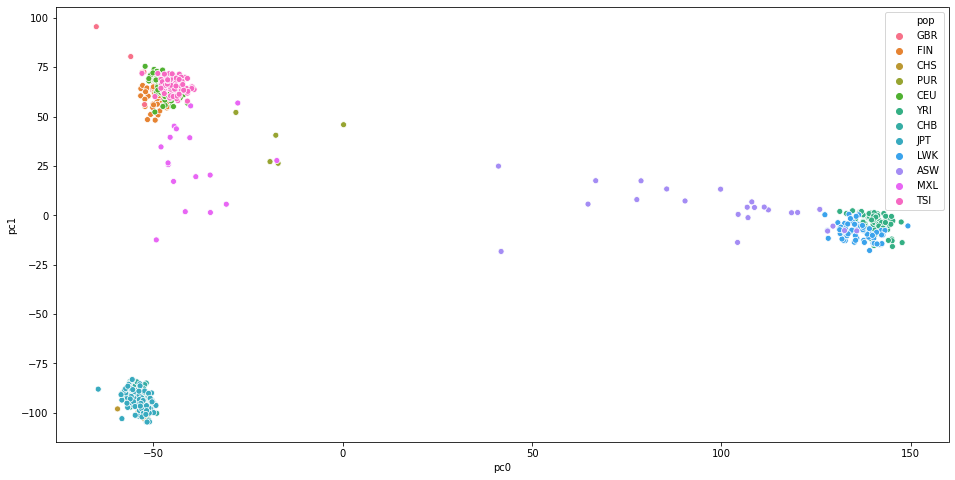

In [102]:
ax = sns.scatterplot(data=dsviz, x='pc0', y='pc1', hue='pop')
plt.gcf().set_size_inches(16, 8)